# Exercise 3: Bayes and EM

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
6. Answer to the qualitative question should be written in **markdown** cells (with $\LaTeX$ support).

## In this exercise you will perform the following:
1. Implement EM algorithm.
1. Implement Naive Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** 308068378 ***

In [16]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [51]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data ( 10 points)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

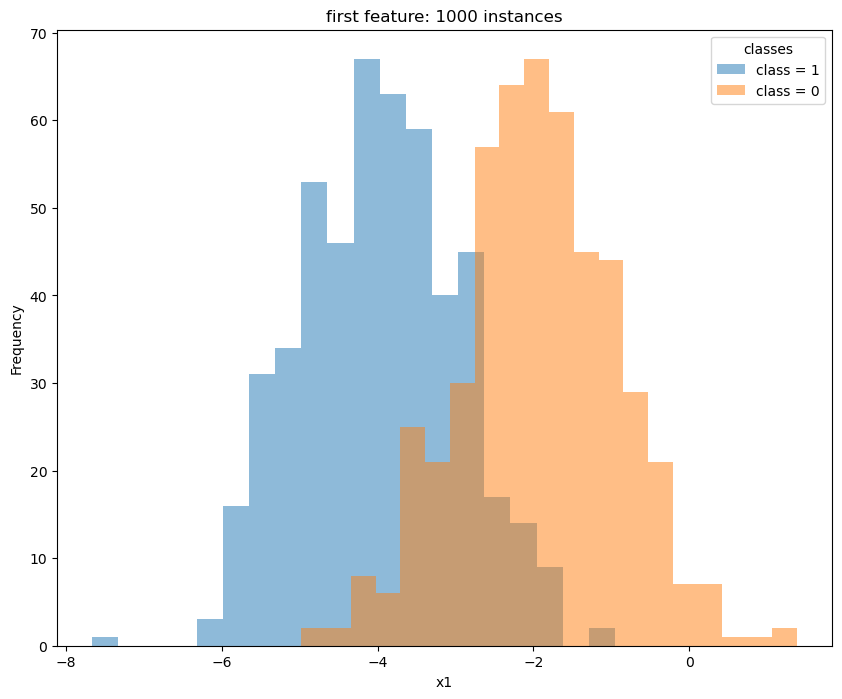

In [4]:
plt.hist(X_training[0:1000,0][y_training[:1000]==1],bins=20,alpha=0.5,label="class = 1")
plt.hist(X_training[0:1000,0][y_training[:1000]==0],bins=20,alpha=0.5,label="class = 0")
plt.xlabel('x1')
plt.ylabel('Frequency')
plt.title('first feature: 1000 instances')
plt.legend(title="classes")
plt.show()

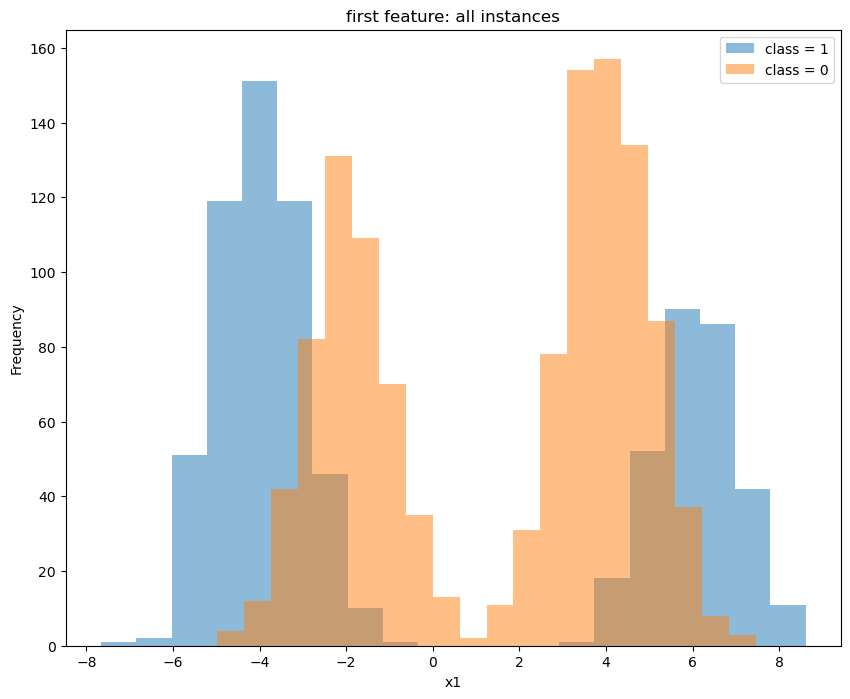

In [5]:
plt.hist(X_training[:,0][y_training==1],bins=20,alpha=0.5,label="class = 1")
plt.hist(X_training[:,0][y_training==0],bins=20,alpha=0.5,label="class = 0")
plt.xlabel('x1')
plt.ylabel('Frequency')
plt.title('first feature: all instances')
plt.legend()
plt.show()

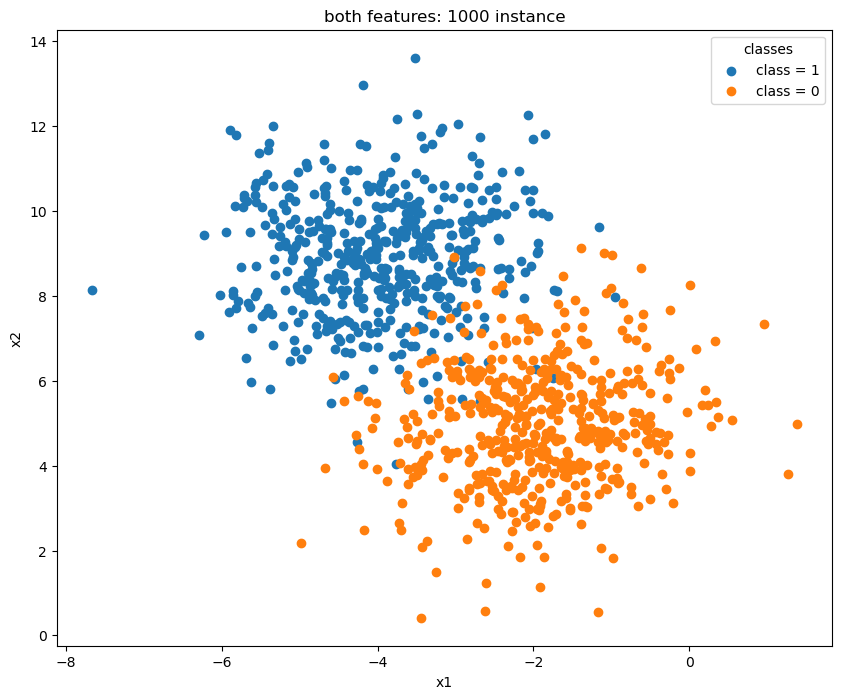

In [6]:

plt.scatter(X_training[:1000,0][y_training[:1000] == 1],X_training[:1000,1][y_training[:1000] == 1],label="class = 1")
plt.scatter(X_training[:1000,0][y_training[:1000] == 0],X_training[:1000,1][y_training[:1000] == 0],label="class = 0")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('both features: 1000 instance')
# Add legend
plt.legend(title='classes')



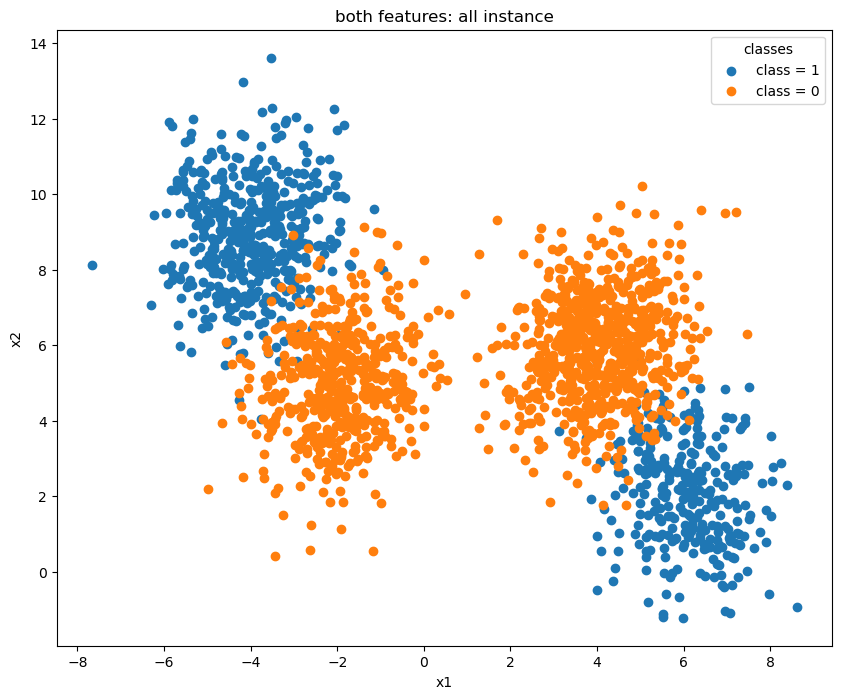

In [7]:
plt.scatter(X_training[:,0][y_training == 1],X_training[:,1][y_training == 1],label="class = 1")
plt.scatter(X_training[:,0][y_training == 0],X_training[:,1][y_training == 0],label="class = 0")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('both features: all instance')

# Add legend
plt.legend(title='classes')
plt.show()


## Normal distribution pdf (10 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write efficient vectorized code

In [8]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    pdf = (1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((data-mu)/sigma)**2))
    return pdf

## Expectation Maximization (30 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use negative log likelihood as the cost function:
$$
cost(x) = \sum_{i=1}^{m}-log\bigg(\sum_{j=1}^{k}w_j * pdf(x_i; \mu_j, \sigma_j)\bigg)
$$

\* Where i is the index of the instances (from 1 to m) and j is the index of the gaussian in the GMM (from 1 to k). 

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function (this function calls the init_params and then iteratively calls expectation and maximization)
1. get_dist_params - return the params of the distribution (the GMM distribution) 

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [9]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
       
    def __init__(self, k=1, n_iter=1000, eps=0.01,random_state=1):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps

    # initial guesses for parameters
    def init_params(self, data):
        
        self.ws = np.full(self.k, 1.0 / self.k)
        self.mus = []
        self.sigmas = []
        # Guess mu as center of K quantiles
        quat_data, bins = pd.qcut(data, self.k, retbins=True, labels=False)
        self.mus = (bins[:-1] + bins[1:]) / 2
        # Guess sigma as empiric sigma
        self.sigmas = np.array([np.sqrt(np.mean((data[quat_data == k] - self.mus[k]) ** 2)) for k in range(self.k)])

    def expectation(self, data):
        m = len(data)
        respon = np.zeros((m, self.k))
        
        for i in range(m):
            for j in range(self.k):
                respon[i, j] = self.ws[j] * norm_pdf(data[i], self.mus[j], self.sigmas[j])
            respon[i] /= np.sum(respon[i])
        
        return respon
    
    def maximization(self, data,respon):
        
        m = len(data)
        sum_responsibilities = np.sum(respon, axis=0)
        self.ws = sum_responsibilities / m
        for j in range(self.k): 
            self.mus[j] = np.sum(respon[:, j] * data) / sum_responsibilities[j]
            self.sigmas[j] = np.sqrt(np.sum(respon[:, j] * (data - self.mus[j]) ** 2) / sum_responsibilities[j])
        
    
    def fit(self, data):
        self.init_params(data)

        prev_cost = np.inf
        for _ in range(10):
            responsibilities = self.expectation(data)
            self.maximization(data, responsibilities)
            

            ## Calculate negative log-likelihood - cost function
            cost = -np.sum(np.log(np.sum(self.ws * norm_pdf(data[:, np.newaxis], self.mus, self.sigmas))))

            if prev_cost - cost < self.eps:
                break
        prev_cost = cost
        
    def get_dist_params(self):
        return  self.mus, self.sigmas
    

### Naive Bayes (30 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [11]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gaussian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of Gaussians in each dimension
    random_state : int
      Random number generator seed for random parameter initialization.
    """

    def __init__(self, k=2,random_state=1):
        self.k = k
        self.class_gaussians = {}
        self.class_labels = None
        self.prior_probs = None

    def fit(self, X, y):
        self.prior_probs = np.bincount(y) / len(y)
        self.class_labels = np.unique(y)
        
        for label in self.class_labels:
            class_data = X[y == label]
            class_gaussians = {}
            for feature in range(X.shape[1]):
                feature_data = class_data[:, feature]
                em_model = EM(k=self.k)
                em_model.fit(feature_data)
                class_gaussians[feature] = em_model
            self.class_gaussians[label] = class_gaussians
        return self.class_gaussians

    def calculate_likelihood(self, x, em_models):
        likelihood = 1.0
        for feature, em_model in em_models.items():
            mus, sigmas = em_model.get_dist_params()
            pdf = np.sum(em_model.ws * norm_pdf(x[feature], mus, sigmas))
            likelihood *= pdf
        return likelihood

    def predict(self, X):
        predictions = []
        for instance in X:
            max_posterior = -np.inf
            predicted_class = None
            for class_label, em_models in self.class_gaussians.items():
                likelihood = self.calculate_likelihood(instance, em_models)
                posterior = likelihood * self.prior_probs[class_label]
                if posterior > max_posterior:
                    max_posterior = posterior
                    predicted_class = class_label
            predictions.append(predicted_class)
        return np.array(predictions)


## Model evaluation (10 points)

1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit the Naive Bayes model. Remember that you need to select the number of Gaussians in the EM.
1. Print the training and test accuracies for the model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for the model (for this you need to use the training set as the input)

Use all the training set points:
1. Repeat sections 2-4 for all the training set points

### Model evalution for  the first 1000 points 

Training Accuracy: 0.966
Test Accuracy: 0.942


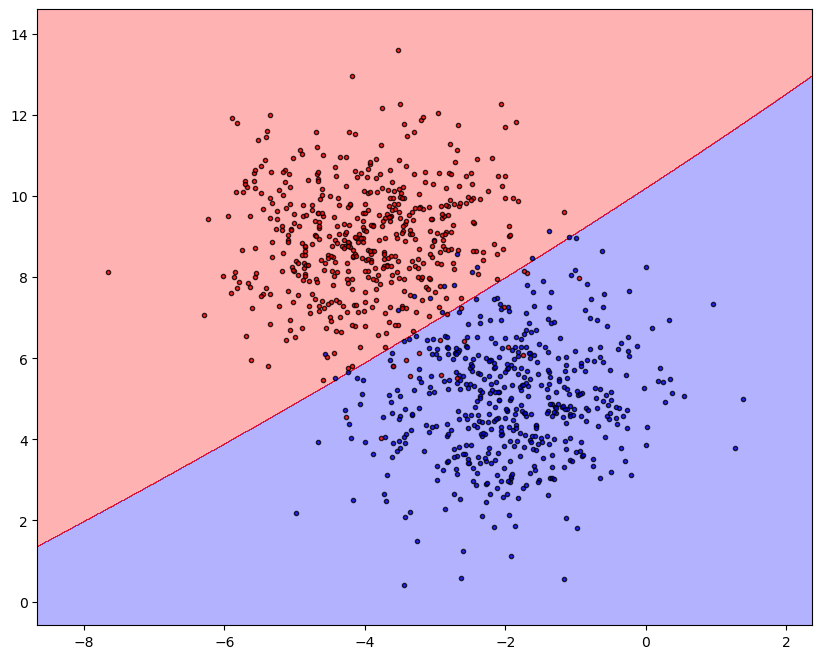

In [12]:
NB = NaiveBayesGaussian(k=1)
NB.fit(X_training[:1000], y_training[:1000])
pred_train = NB.predict(X_training[:1000])
pred_test =  NB.predict(X_test[:500])

train_accuracy = np.mean(pred_train == y_training[:1000])
test_accuracy = np.mean(pred_test == y_test[:500])


print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

plot_decision_regions(X_training[:1000], y_training[:1000],NB)

### Model evalution for  all dataset

Training Accuracy: 0.921
Test Accuracy: 0.901


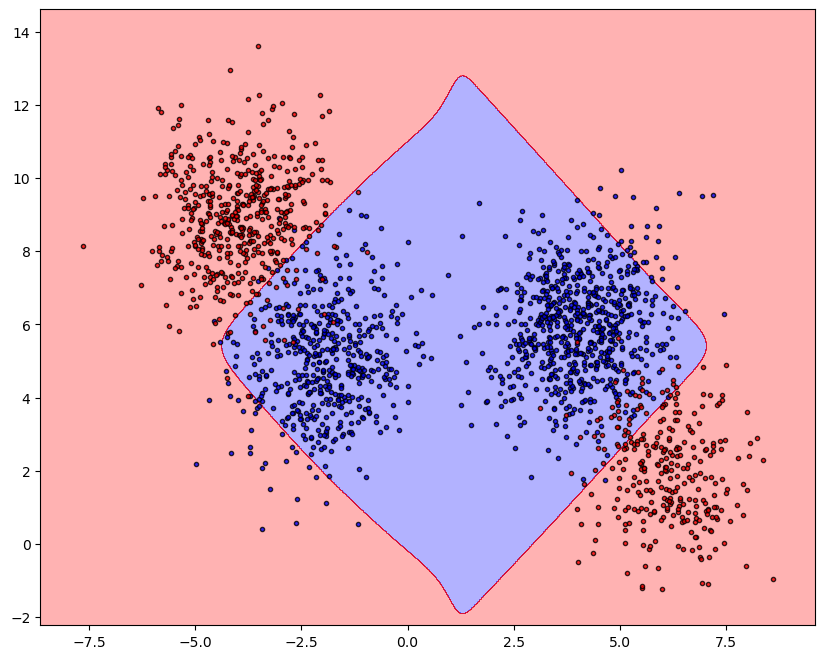

In [13]:
NB = NaiveBayesGaussian(k=2)
NB.fit(X_training, y_training)
pred_train = NB.predict(X_training)
pred_test =  NB.predict(X_test)

train_accuracy = np.mean(pred_train == y_training)
test_accuracy = np.mean(pred_test == y_test)


print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

plot_decision_regions(X_training, y_training,NB)

## Open question (10 points) 

In the previous course we implemented the Logistic regression algorithm and we have now completed the implementation of Naive Bayes using EM. 

- Generate one dataset that you think Naive Bayes will work better than Logistic Regression.
- Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
- Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

In [14]:
# You are provided with the Logistic regression class if you need it

class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        
        rgen = np.random.RandomState(self.random_state)
        self.theta = np.random.normal(loc=0.0, scale=1, size=1 + X.shape[1])
        self.cost = []
        old_cost = 0
        output = []
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (output - y)
            self.theta[1:] -= self.eta * X.T.dot(errors)
            self.theta[0] -= self.eta * errors.sum()
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = (-y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))).sum() / X.shape[0]
            if abs(cost - old_cost) < self.eps:
                break
            old_cost = cost
            self.cost.append(cost)
    
    def predict(self, X):
        """Return the predicted class label"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.theta[1:]) + self.theta[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))


#### Your answer here ####


## Naive Bayes will work better than Logistic Regression

### i have created a data set that using a line that logisic regrassion is doing he will not able to that correct, where EM can do this using the disterbutions of each class.

In [17]:
from sklearn.datasets import make_blobs

np.random.seed(412)


points = 2000

centers_0 = [[-2, -6], [-2, -2]]
x_class0, y_class0 = make_blobs(n_samples=points, centers=centers_0, random_state=123)

centers_1 = [[4,4], [2, 0]]
x_class1, y_class1 = make_blobs(n_samples=points, centers=centers_1, random_state=123)


x1 = np.concatenate((x_class0[:, 0], x_class1[:, 0]))
x2 = np.concatenate((x_class0[:, 1], x_class1[:, 1]))
y = np.concatenate((y_class0, y_class1))


shuffled_indices = np.random.permutation(len(x1))
x1 = x1[shuffled_indices]
x2 = x2[shuffled_indices]
y = y[shuffled_indices]

x = np.column_stack((x1, x2))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

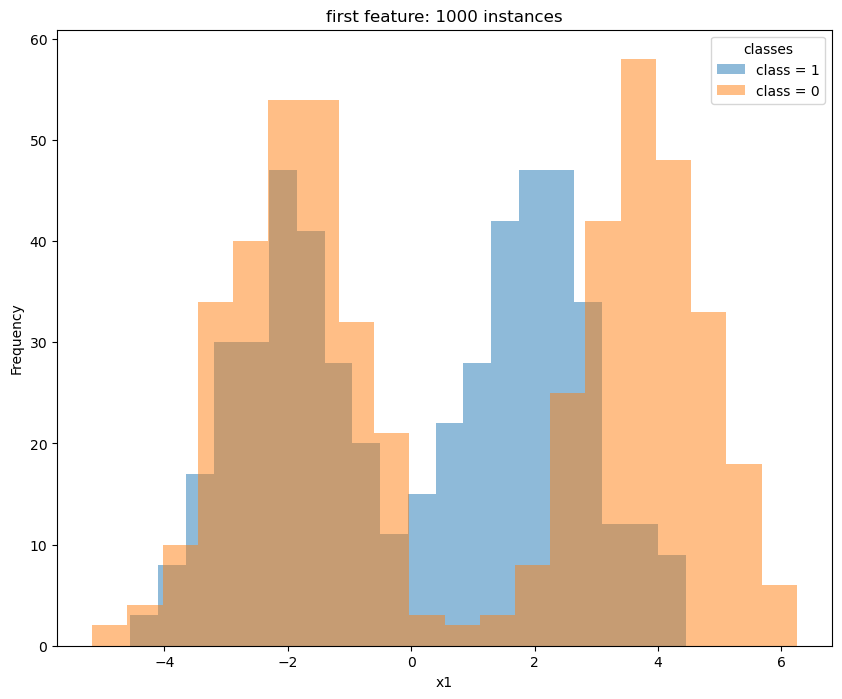

In [18]:
plt.hist(x_train[0:1000,0][y_train[:1000]==1],bins=20,alpha=0.5,label="class = 1")
plt.hist(x_train[0:1000,0][y_train[:1000]==0],bins=20,alpha=0.5,label="class = 0")
plt.xlabel('x1')
plt.ylabel('Frequency')
plt.title('first feature: 1000 instances')
plt.legend(title="classes")
plt.show()

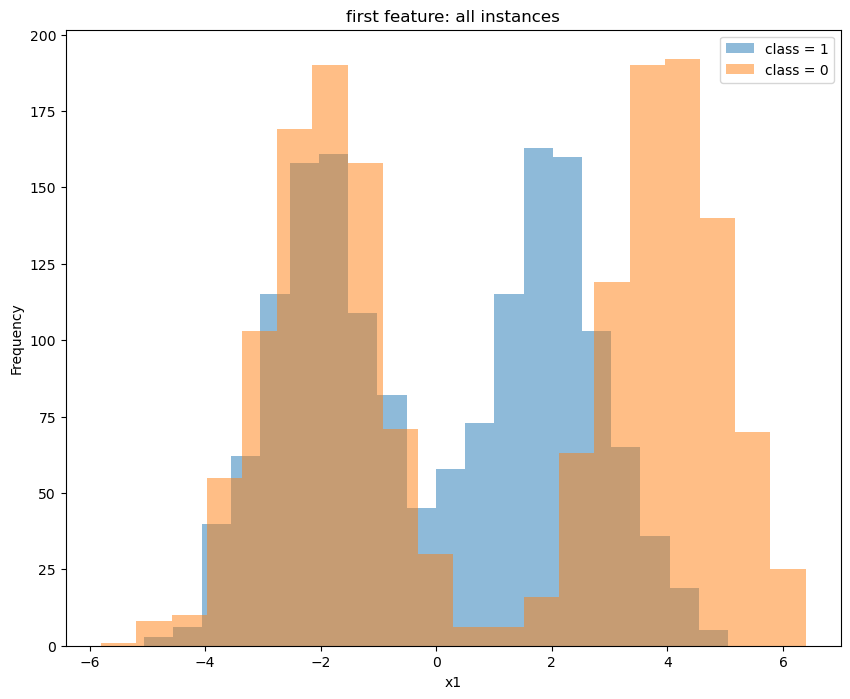

In [19]:
plt.hist(x_train[:,0][y_train==1],bins=20,alpha=0.5,label="class = 1")
plt.hist(x_train[:,0][y_train==0],bins=20,alpha=0.5,label="class = 0")
plt.xlabel('x1')
plt.ylabel('Frequency')
plt.title('first feature: all instances')
plt.legend()
plt.show()

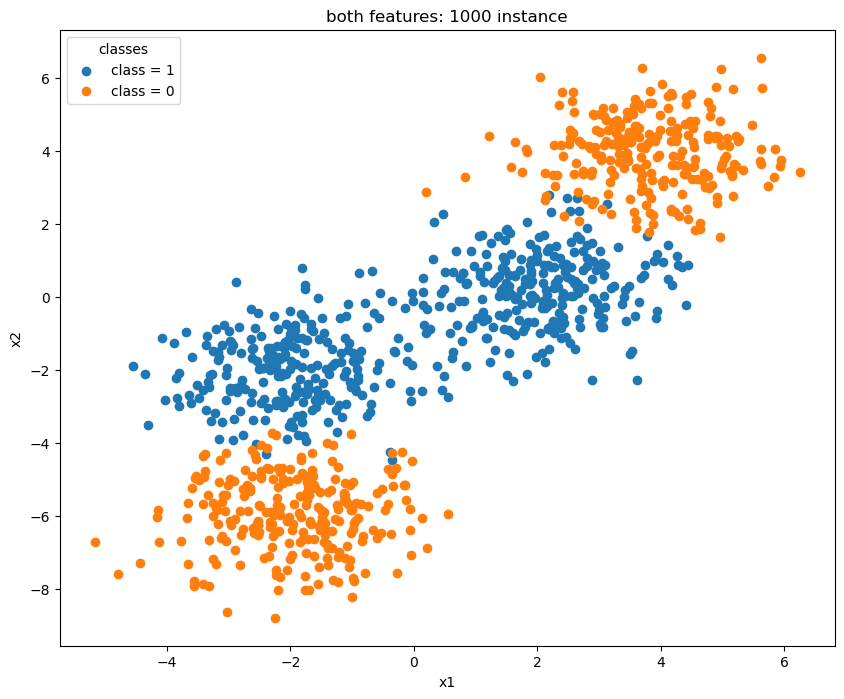

In [20]:
plt.scatter(x_train[:1000,0][y_train[:1000] == 1],x_train[:1000,1][y_train[:1000] == 1],label="class = 1")
plt.scatter(x_train[:1000,0][y_train[:1000] == 0],x_train[:1000,1][y_train[:1000] == 0],label="class = 0")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('both features: 1000 instance')
# Add legend
plt.legend(title='classes')



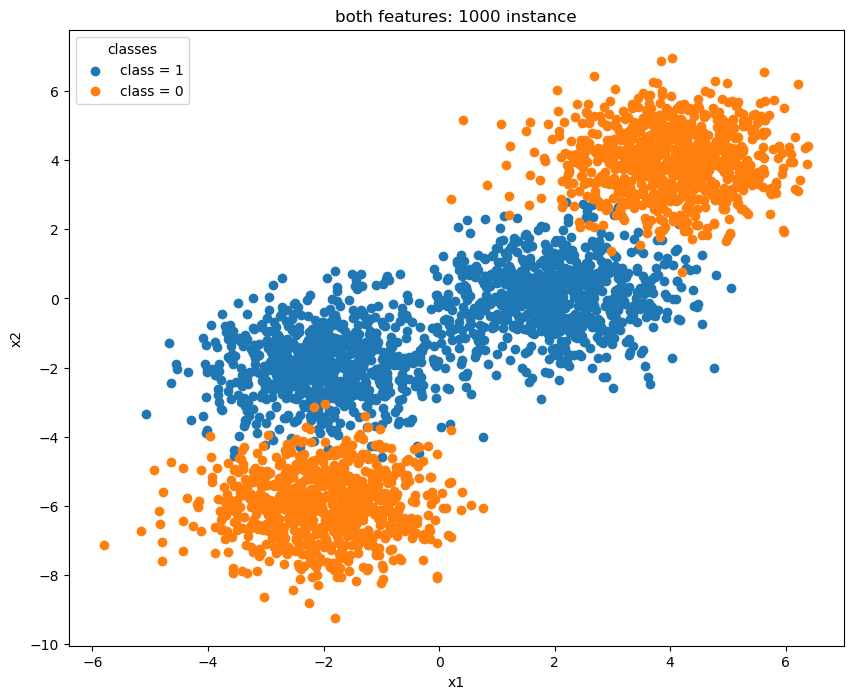

In [21]:
plt.scatter(x_train[:,0][y_train == 1],x_train[:,1][y_train == 1],label="class = 1")
plt.scatter(x_train[:,0][y_train == 0],x_train[:,1][y_train == 0],label="class = 0")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('both features: 1000 instance')
# Add legend
plt.legend(title='classes')



In [22]:
LR = LogisticRegressionGD()
LR.fit(x_train, y_train)
y_pred_train = LR.predict(x_train)
y_pred_test = LR.predict(x_test)
train_accuracy = np.mean(y_pred_train == y_train)
test_accuracy = np.mean(y_pred_test == y_test)
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Training Accuracy: 0.6384375
Test Accuracy: 0.605


### As we can see from the accuracy result, the NaiveBayesGaussian doing much better job!

In [23]:
em = NaiveBayesGaussian(k=1)
em.fit(x_train,y_train)
y_pred_train = em.predict(x_train)
y_pred_test = em.predict(x_test)
train_accuracy = np.mean(y_pred_train == y_train)
test_accuracy = np.mean(y_pred_test == y_test)
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.95625
Test Accuracy: 0.955


 
# Logistic Regression will work better than Naive Bayes using EM. 

### I have created a data set that split the range of x1 and x2 the same, and mapped the y classes to split in a linear corraltion for x1 and x2 for each of the classes. 
### With that way the logistic regrassion will mange to split the data  perfectly but the NB-EM will preform worse becauase the distrbution of the classes is hard to find for NB.

In [44]:
np.random.seed(412)
x1_min, x1_max = -10, 10
x2_min, x2_max = -10, 10


num_points = 2000
x1 = np.random.uniform(x1_min, x1_max, num_points)
x2 = np.random.uniform(x2_min, x2_max, num_points)

slope = 0.7
x2_slope = x1 * slope
y = np.where(x2 < x2_slope, 0, 1) 
x = np.column_stack((x1, x2))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)



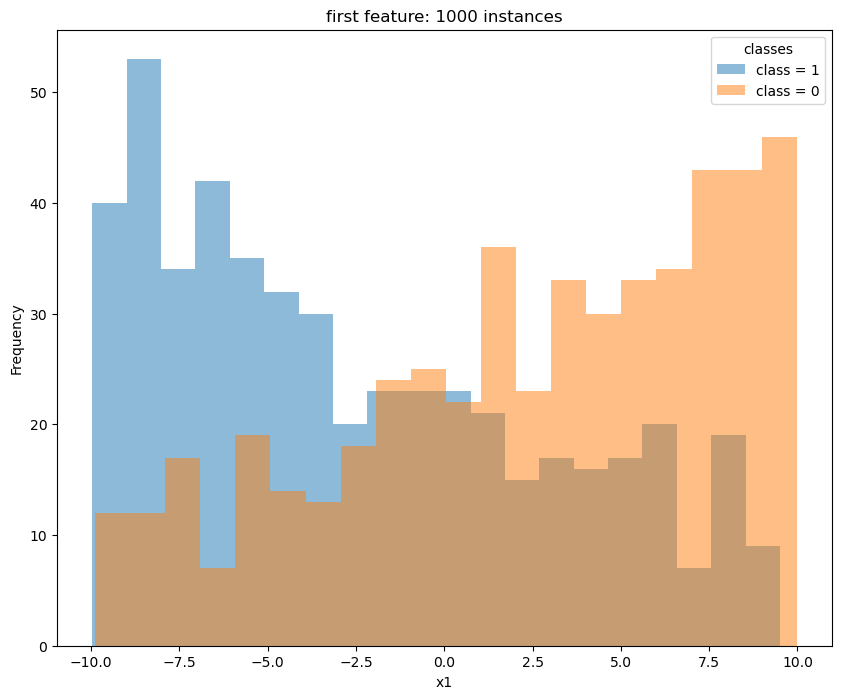

In [45]:
plt.hist(x_train[0:1000,0][y_train[:1000]==1],bins=20,alpha=0.5,label="class = 1")
plt.hist(x_train[0:1000,0][y_train[:1000]==0],bins=20,alpha=0.5,label="class = 0")
plt.xlabel('x1')
plt.ylabel('Frequency')
plt.title('first feature: 1000 instances')
plt.legend(title="classes")
plt.show()

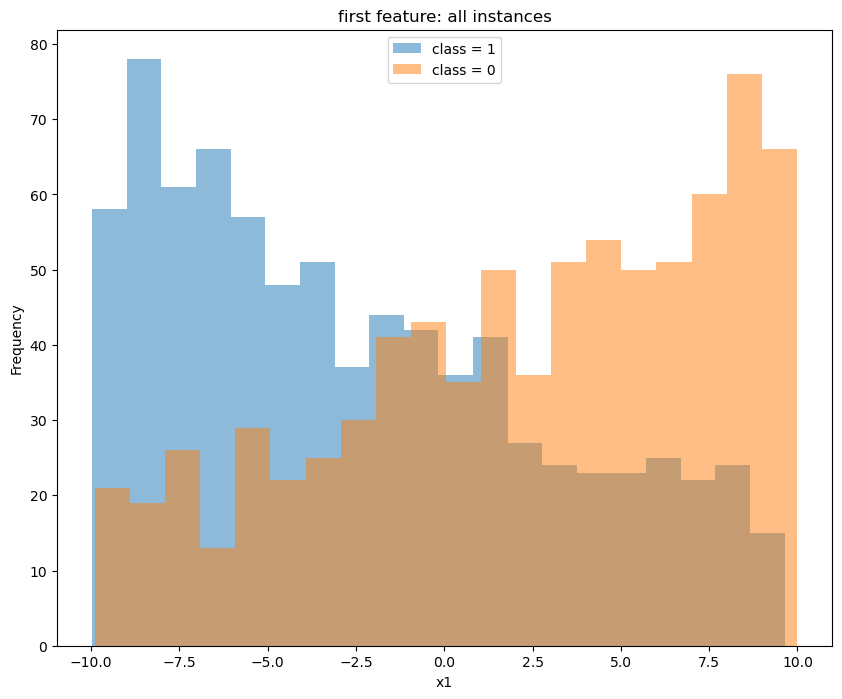

In [46]:
plt.hist(x_train[:,0][y_train==1],bins=20,alpha=0.5,label="class = 1")
plt.hist(x_train[:,0][y_train==0],bins=20,alpha=0.5,label="class = 0")
plt.xlabel('x1')
plt.ylabel('Frequency')
plt.title('first feature: all instances')
plt.legend()
plt.show()

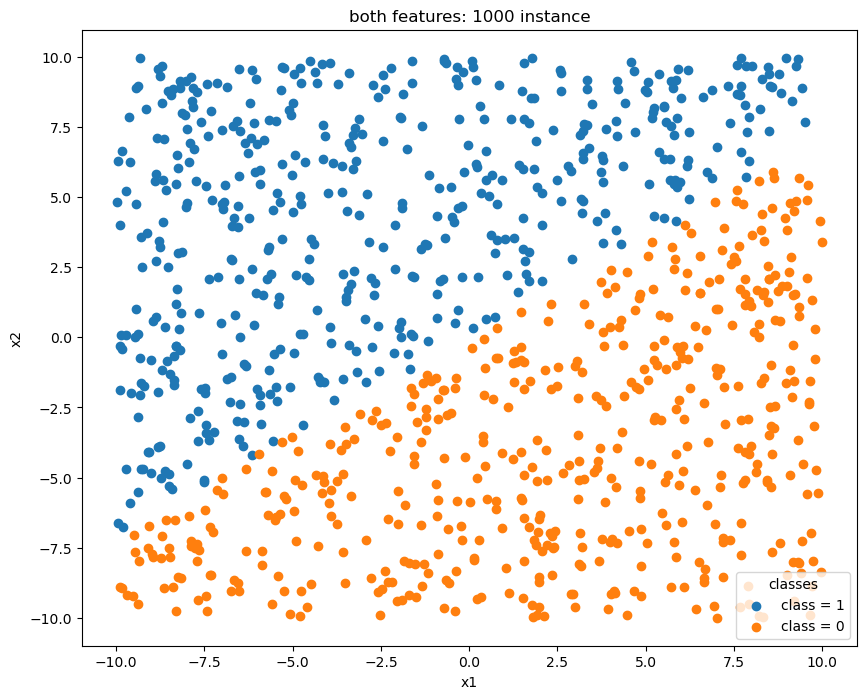

In [47]:
plt.scatter(x_train[:1000,0][y_train[:1000] == 1],x_train[:1000,1][y_train[:1000] == 1],label="class = 1")
plt.scatter(x_train[:1000,0][y_train[:1000] == 0],x_train[:1000,1][y_train[:1000] == 0],label="class = 0")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('both features: 1000 instance')
# Add legend
plt.legend(title='classes')



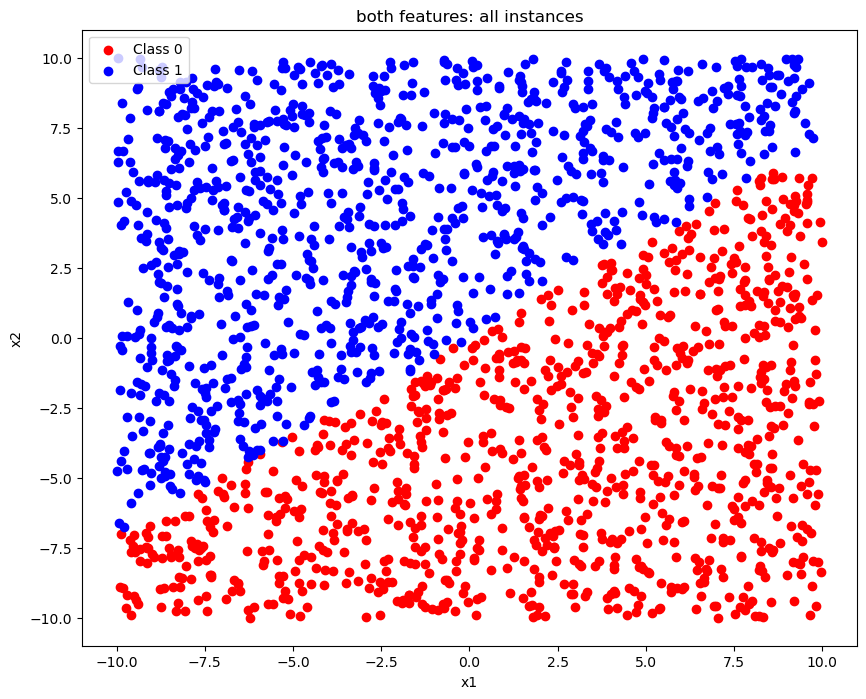

In [48]:
plt.scatter(x1[y==0], x2[y==0], c='r', label='Class 0')
plt.scatter(x1[y==1], x2[y==1], c='b', label='Class 1')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('both features: all instances')
plt.legend()

plt.show()

## best result for LR

In [49]:
LR = LogisticRegressionGD()
LR.fit(x_train, y_train)
y_pred_train = LR.predict(x_train)
y_pred_test = LR.predict(x_test)
train_accuracy = np.mean(y_pred_train == y_train)
test_accuracy = np.mean(y_pred_test == y_test)
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Training Accuracy: 0.998125
Test Accuracy: 0.9975


## good result but the winne is LR!

In [50]:
em = NaiveBayesGaussian(k=1)
em.fit(x_train,y_train)
y_pred_train = em.predict(x_train)
y_pred_test = em.predict(x_test)
train_accuracy = np.mean(y_pred_train == y_train)
test_accuracy = np.mean(y_pred_test == y_test)
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.899375
Test Accuracy: 0.875
